In [1]:
#需要load data(single month前面那些)
#find out ground（single prediction那部分）
#找到词（log odds file handle 那些）
#回归，logodds
#valid分开

In [1]:
import os 
import sys
sys.path.append('/home/zbohan/projects/')
#sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics import accuracy_score

from src.data.make_dataset import build_dataset
from src.models.word2vec.User2Subreddit import User2Subreddit

from sklearn.metrics import auc, roc_curve
from src.data.SubredditUserDataset import SubredditUserDataset
import bz2
import lzma
import json
import zstandard as zstd
from json import JSONDecodeError
from collections import Counter
import math
import pandas as pd
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import numpy as np

In [2]:
from nltk import word_tokenize
from nltk.util import ngrams
import nltk

In [3]:
year_month = '2019-04'

network_path = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/' + year_month + '_filtered.tsv'
flair_directory ='/shared/0/projects/reddit-political-affiliation/data/flair-affiliations/' + year_month + '.tsv'
#flair_directory='/home/zbohan/projects/src/data/'+year_month+'.tsv'

In [4]:
flair_files = glob.glob(flair_directory)

In [6]:
def read_political_affiliations(files):
    user_to_politic_counts = defaultdict(Counter)

    for fname in tqdm(files):
        with open(fname, 'rt') as f:
            for line in f:
                user, politics, freq = line.split('\t')
                user_to_politic_counts[user][politics] += int(freq)

    print("User to politic counts: " + str(len(user_to_politic_counts)))
    print(list(user_to_politic_counts.items())[:10])

    user_to_politics = {}
    for u, pc in user_to_politic_counts.items():
        if len(pc) > 1:
            continue
        user_to_politics[u] = list(pc.keys())[0]

    print('Saw political affiliations for %d users' % len(user_to_politics))
    return convert_affiliations_to_binary(user_to_politics)


def convert_affiliations_to_binary(user_to_politics):
    for user, politics in user_to_politics.items():
        if politics == "Democrat":
            user_to_politics[user] = 0
        else:
            user_to_politics[user] = 1

    return user_to_politics

In [7]:
#ground truth political labels.
ground_pol=read_political_affiliations(flair_files)

100%|██████████| 1/1 [00:00<00:00, 63.49it/s]

User to politic counts: 2589
[('WatchMaga', Counter({'Republican': 2})), ('BasedMedicalDoctor', Counter({'Republican': 2})), ('Damemezaredadremez', Counter({'Republican': 2})), ('joeohegna', Counter({'Republican': 1})), ('Deplorable_scum', Counter({'Republican': 2})), ('TheRabbidHD', Counter({'Republican': 2})), ('Paladin-Arda', Counter({'Democrat': 2})), ('Trumpwillalwayswin', Counter({'Republican': 2})), ('daw-nee-yale', Counter({'Republican': 1})), ('BigcatTV', Counter({'Republican': 2}))]
Saw political affiliations for 2588 users


In [8]:
def get_file_handle(file_path):
    ext = file_path.split('.')[-1]

    if ext == "bz2":
        return bz2.open(file_path)
    elif ext == "xz":
        return lzma.open(file_path)

    raise AssertionError("Invalid extension for " + file_path + ". Expecting bz2 or xz file")

In [9]:
def get_word_frequencies(file_pointer, ground_pol):
    user_word=defaultdict(Counter)
    left_word_freq, right_word_freq = Counter(), Counter()
    for count, line in enumerate(file_pointer):
        try:
            submission = json.loads(f.readline().strip())
            username, text = submission['author'], submission['body']

            if username in ground_pol:
                unigram=word_tokenize(text)
                bigram=ngrams(unigram,2)
                for uni in unigram:
                    if len(uni)<=20 and len(uni)>1 and 'http' not in uni:#remove some noisy term and hyper link
                        user_word[username][uni]+=1
                        if ground_pol[username]==1:
                            right_word_freq[uni]+=1
                        else:
                            left_word_freq[uni]+=1
                for bi in bigram:
                    if len(bi[0])<=20 and len(bi[1])<=20 and 'http' not in bi[0] and 'http' not in bi[1]:
                        user_word[username][bi[0]+' '+bi[1]]+=1
                              
                    
        except (JSONDecodeError, AttributeError) as e:
            print("Failed to parse line: {} with error: {}".format(line, e))

        if count % 1000000 == 0 and count > 0:
            print("Completed %d lines" % (count))
            #break
    return user_word,left_word_freq, right_word_freq

In [10]:
file_path = '/shared/2/datasets/reddit-dump-all/RC/RC_'+year_month+'.xz'
f = get_file_handle(file_path)

In [203]:
#get word frequency used by all users in this month
user_word,left_counts, right_counts = get_word_frequencies(f,ground_pol)
print("Number of words from left users: {}".format(len(left_counts)))
print("Number of words from right users: {}".format(len(right_counts)))

Completed 1000000 lines
Completed 2000000 lines
Completed 3000000 lines
Completed 4000000 lines
Completed 5000000 lines
Completed 6000000 lines
Completed 7000000 lines
Completed 8000000 lines
Completed 9000000 lines
Completed 10000000 lines
Completed 11000000 lines
Completed 12000000 lines
Completed 13000000 lines
Completed 14000000 lines
Completed 15000000 lines
Completed 16000000 lines
Completed 17000000 lines
Completed 18000000 lines
Completed 19000000 lines
Completed 20000000 lines
Completed 21000000 lines
Completed 22000000 lines
Completed 23000000 lines
Completed 24000000 lines
Completed 25000000 lines
Completed 26000000 lines
Completed 27000000 lines
Completed 28000000 lines
Completed 29000000 lines
Completed 30000000 lines
Completed 31000000 lines
Completed 32000000 lines
Completed 33000000 lines
Completed 34000000 lines
Completed 35000000 lines
Completed 36000000 lines
Completed 37000000 lines
Completed 38000000 lines
Completed 39000000 lines
Completed 40000000 lines
Completed

In [14]:
#save users' words freq for later.
import json
reg_dir='/shared/0/projects/reddit-political-affiliation/data/word2vec/log-reg-feat/'+year_month+'.json'
with open(reg_dir, 'w') as fp:
    json.dump(user_word, fp)

# Logodds on ground truth

In [152]:
out_file = '/shared/0/projects/reddit-political-affiliation/data/word2vec/log-odds/' + year_month + '_ground_left.json'

with open(out_file, 'w') as fp:
    json.dump(dict(left_counts), fp)
    
out_file = '/shared/0/projects/reddit-political-affiliation/data/word2vec/log-odds/' + year_month + '_ground_right.json'

with open(out_file, 'w') as fp:
    json.dump(dict(right_counts), fp)

In [16]:
def LoadCounts(filename, min_count=0, stopwords=set()):
    result = defaultdict(int)
    word_counts = json.load(open(filename))
    for word, count in word_counts.items():
        if count >= min_count and word not in stopwords:
              result[word] = count
    return result
  
def LoadStopwords(filename):
    stopwords = set()
    for line in open(filename):
        for word in line.split():
            if word:
                stopwords.add(word)
    return stopwords


def ComputeLogOdds(counts1, counts2, prior):
    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word] + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())


    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    return delta

In [17]:
def combine_count_log_odds(logodds,neg_counts,pos_counts):
    neg_counts['frequency'] = neg_counts['count'] / neg_counts['count'].sum()
    neg_logodds = logodds[logodds['log_odds'] < 0]
    neg_logodds = neg_logodds.merge(neg_counts,on='ngram')
    
    pos_counts['frequency'] = pos_counts['count'] / pos_counts['count'].sum()
    pos_logodds = logodds[logodds['log_odds'] > 0]
    pos_logodds = pos_logodds.merge(pos_counts,on='ngram')
    return pd.concat([neg_logodds,pos_logodds])#,pos_logodds,neg_logodds

In [18]:
def plot_log_odds(odds_freq,sig_val=1.96,min_freq=1e-5,max_odds=100,min_odds=-100):
    odds_freq = odds_freq[odds_freq['frequency'] >= min_freq]
    x_vals = list(odds_freq['frequency'])
    y_vals = list(odds_freq['log_odds'])
    y_vals = [max(v,min_odds) for v in y_vals] 
    y_vals = [min(v,max_odds) for v in y_vals]
    sizes = [min(12,2*abs(v)) for v in y_vals]
    #sizes=[10]*len(sizes)
    neg_color, pos_color, insig_color = ('green', 'purple', 'grey')
    colors = []
    annots = []
    pos_list={}
    neg_list={}
    
    for index, row in odds_freq.iterrows():
        if row['log_odds'] > sig_val:
            colors.append(pos_color)
            annots.append(row['ngram'])
            pos_list[row['ngram']]=row['log_odds']
        elif row['log_odds'] < -sig_val:
            colors.append(neg_color)
            annots.append(row['ngram'])
            neg_list[row['ngram']]=row['log_odds']
        else:
            colors.append(insig_color)
            annots.append(None)

    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0,s=1)
    for i, annot in enumerate(annots):
        if annot is not None:
            ax.annotate(annot, (x_vals[i], y_vals[i]), color=colors[i],size=sizes[i])
    ax.set_xscale('log')
    ax.set_xlabel('frequency')
    ax.set_ylabel('log odds')
    ax.set_yscale('symlog',linthreshy=15)
    return pos_list,neg_list

In [19]:
from nltk.corpus import stopwords

# SETTINGS
first_file = '/shared/0/projects/reddit-political-affiliation/data/word2vec/log-odds/' + year_month + '_ground_left.json'
second_file = '/shared/0/projects/reddit-political-affiliation/data/word2vec/log-odds/' + year_month + '_ground_right.json'
min_count =5
stop = stopwords.words('english')
prior = defaultdict(lambda:0)
out_file = '/shared/0/projects/reddit-political-affiliation/data/word2vec/log-odds/' + year_month + '_results.tsv'

counts1 = LoadCounts(first_file, min_count, stop)
counts2 = LoadCounts(second_file, min_count, stop)
print(len(counts1),len(counts2))
#prior = LoadCounts(prior, min_count, stopwords)
delta = ComputeLogOdds(counts1, counts2, prior)

# count_file='/shared/0/projects/reddit-political-affiliation/data/word2vec/'+year_month+'_count.tsv'
# with open(count_file, 'w') as fp:
#     for word, log_odds in sorted(delta.items(), key=lambda x: x[1]):
#         fp.write("{}\t{:.3f}\n".format(word, log_odds))


1102 6146


In [22]:
pd_left_counts=pd.DataFrame(dict(counts1).items(),columns=['ngram','count'])
pd_right_counts=pd.DataFrame(dict(counts2).items(),columns=['ngram','count'])
logodds=pd.DataFrame(dict(delta).items(),columns=['ngram','log_odds'])

In [21]:
odd_freq=combine_count_log_odds(logodds,pd_left_counts,pd_right_counts)

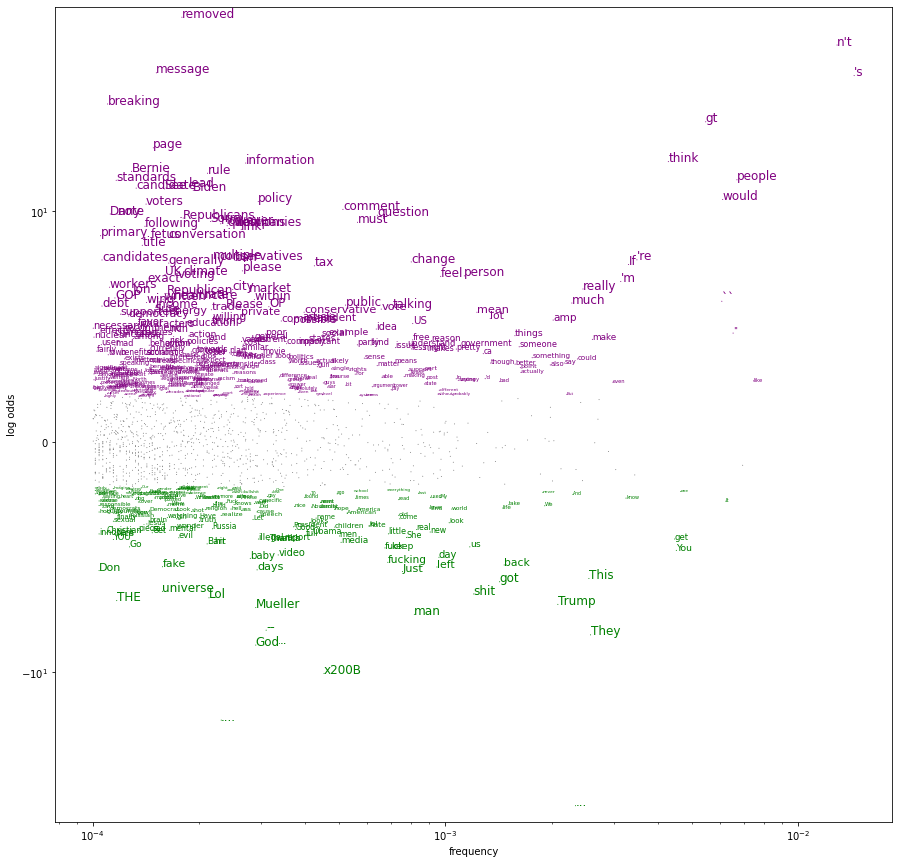

In [162]:
#2019-05
p,n=plot_log_odds(odd_freq,sig_val=1.96,min_freq=1e-4,max_odds=50,min_odds=-50)

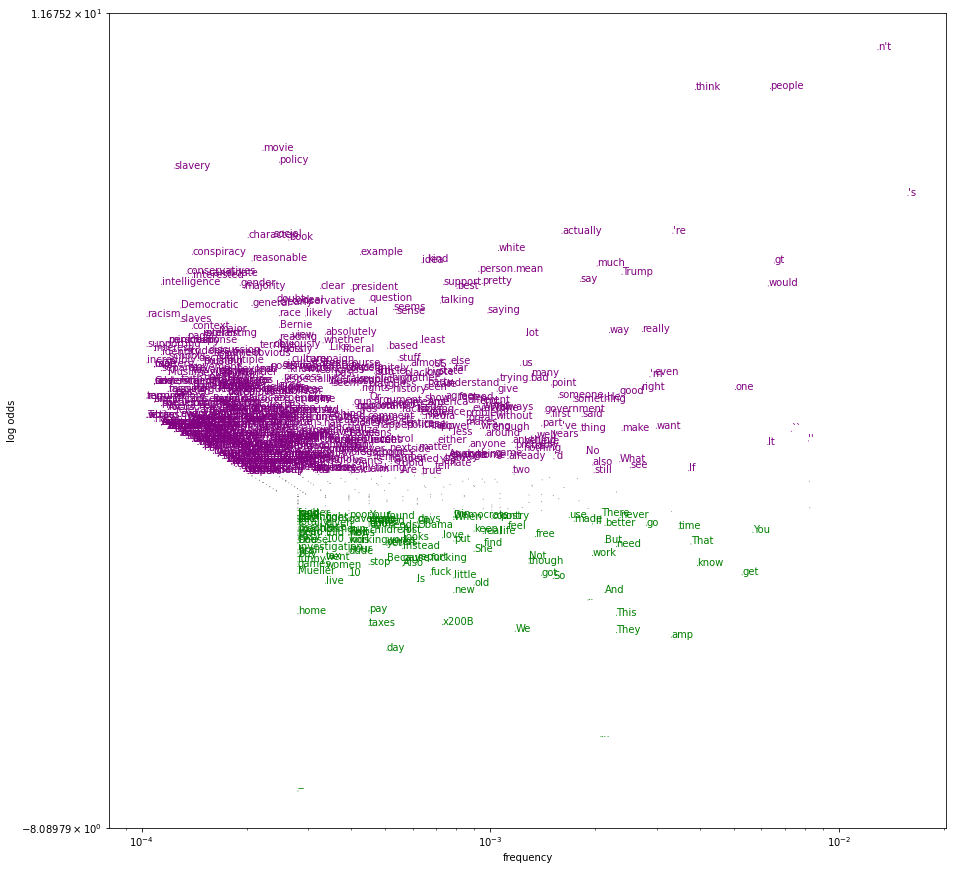

In [128]:
#2019-04 with small sig_val(a bad scaled plot, ignore this)
p,n=plot_log_odds(odd_freq,sig_val=0.5,min_freq=1e-4,max_odds=10,min_odds=-10)

# Logistic Regression

# load validation set from saved files and delete them from total user_word to get training set

In [25]:
dataset, training, validation, pol_validation, vocab = build_dataset(network_path, flair_directory)


Building vocab from file:  34%|███▍      | 9524829/28132858 [00:28<00:37, 495778.56it/s]


Building vocab from file:  63%|██████▎   | 17597225/28132858 [00:56<00:30, 348074.32it/s]


Building vocab from file:  89%|████████▉ | 25149409/28132858 [01:27<00:08, 342059.63it/s]


Converting data to PyTorch:   0%|          | 223/5697629 [00:00<43:25, 2186.45it/s]

Length of vocab: 5762539
User count: 5697629
Subreddit count: 64910
User to politic counts: 2589
[('WatchMaga', Counter({'Republican': 2})), ('BasedMedicalDoctor', Counter({'Republican': 2})), ('Damemezaredadremez', Counter({'Republican': 2})), ('joeohegna', Counter({'Republican': 1})), ('Deplorable_scum', Counter({'Republican': 2})), ('TheRabbidHD', Counter({'Republican': 2})), ('Paladin-Arda', Counter({'Democrat': 2})), ('Trumpwillalwayswin', Counter({'Republican': 2})), ('daw-nee-yale', Counter({'Republican': 1})), ('BigcatTV', Counter({'Republican': 2}))]
Saw political affiliations for 2588 users
User to politics training size: {}: 2330
User to politics validation size: {}: 258


Converting data to PyTorch: 100%|██████████| 5697629/5697629 [11:02<00:00, 8598.86it/s] 


Train size: 151917434 Validation size: 16879714


In [109]:
# Load in the actual model
PATH = '/shared/0/projects/reddit-political-affiliation/working-dir/word2vec-outputs/' + year_month + '/9.pt'
embedding_dim = 50

model = User2Subreddit(dataset.num_users(), embedding_dim, len(dataset.subreddit_to_idx))
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

User2Subreddit(
  (u_embeddings): Embedding(5697629, 50)
  (v_embeddings): Embedding(64910, 50)
  (political_layer): Linear(in_features=50, out_features=1, bias=True)
  (before_pol_dropout): Dropout(p=0.5, inplace=False)
)

In [184]:
#our embedding predictions
#used_pol are these users actually included in our model one-month prediction, since some users in validation may not appear in this month.
user_ids, pol_labels,used_pol = [], [], {}

for user, pol_label in pol_validation.items():
    try:
        # User subreddit dataset spans 1 month. Political data spans the year. Some users might not be present
        user_ids.append(dataset.user_to_idx[user])
        pol_labels.append(pol_label)
        used_pol[user]=pol_validation[user]
    except KeyError:
        pass

user_ids = torch.LongTensor(user_ids)
pol_labels = torch.FloatTensor(pol_labels)

emb_p = model.u_embeddings(user_ids)
political_predictions = model.political_layer(emb_p)
political_predictions = torch.sigmoid(political_predictions)

preds = []
for val in political_predictions.detach().numpy():
    if val[0] >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

labels = pol_labels.detach().numpy().astype(int)
accuracy_score(labels, preds)

0.8326180257510729

In [53]:
#user_word=json.load(open(reg_dir))

In [119]:
#load users' word and remove those in validation set to form training set. 
train=json.load(open(reg_dir))
test={}
for val in pol_validation:
    #print(val in train,val)
    if val in train:
        test[val]=train[val]
        del train[val]
    else:
        test[val]={}

2566
2310


In [120]:
for unpre in ground_pol:
    if unpre not in train and unpre not in test:
        train[unpre]={}
#some training users may not appear in this month neither, so just assign an empty feature. This can also be ignored

In [122]:
new_test={}
for t in test:
    if t in used_pol:
        new_test[t]=test[t]
test=new_test# for a fair comparsion with our neural model, just include validation users appear in this month

In [96]:
word_count=Counter()
for key in tqdm(train):
    word_count+=train[key]

100%|██████████| 2330/2330 [02:32<00:00, 15.28it/s]


In [97]:
sorted_count=word_count.most_common()

In [220]:
# top (start,start+dim) frequent words as feature
start=500
dim=2000

In [227]:
uni2id={}
bi2id={}
count=0
for idx,(k,v) in enumerate(sorted_count):
    if count==dim:
        break
    if idx>=start:
        if ' ' in k:
            bi2id[k]=count
        else:
            uni2id[k]=count
        count+=1
        

In [222]:
train_y=[]
test_y=[]
count_0=0
count_1=0
for user in train:
    if ground_pol[user]==0:
        count_0+=1
    else:
        count_1+=1
    train_y.append(ground_pol[user])
for user in test:
    test_y.append(ground_pol[user])
print(count_0,count_1)#left and right users in this month

248 2082


In [228]:
#build training feature matrix
train_matrix=np.zeros((len(train),dim+0))

for idx,user in enumerate(tqdm(train)):
    try:
        #user_id=dataset.user_to_idx[user]
        #emb_p=model.u_embeddings(torch.LongTensor([user_id])).detach().numpy()[0]
        user_x=np.zeros(dim)
        raw_feat=train[user]
        for w in raw_feat.keys():
            if ' ' in w:
                if w in bi2id:
                    user_x[bi2id[w]]=raw_feat[w]
            else:
                if w in uni2id:
                    user_x[uni2id[w]]=raw_feat[w]
        #user_x=np.concatenate((emb_p,user_x))
        train_matrix[idx]=user_x
    except:
        pass

100%|██████████| 2330/2330 [00:01<00:00, 1423.13it/s]


In [229]:
#build test feature matrix
test_matrix=np.zeros((len(test),dim+0))

for idx,user in enumerate(tqdm(test)):
    #user_id=dataset.user_to_idx[user]
    #emb_p=model.u_embeddings(torch.LongTensor([user_id])).detach().numpy()[0]
    user_x=np.zeros(dim)
    raw_feat=test[user]
    for w in raw_feat.keys():
        if ' ' in w:
            if w in bi2id:
                user_x[bi2id[w]]=raw_feat[w]
        else:
            if w in uni2id:
                user_x[uni2id[w]]=raw_feat[w]
    #user_x=np.concatenate((emb_p,user_x))
    test_matrix[idx]=user_x

100%|██████████| 233/233 [00:00<00:00, 1652.65it/s]


In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [232]:
print("Training...patience...")
clf = LogisticRegression(solver='lbfgs',max_iter=1000,n_jobs=4).fit(train_matrix,train_y)
print("Done, let's see!!")

Training...patience...
Done, let's see!!


In [231]:
#lr results
pre_y=clf.predict(test_matrix)
print("Confusion Metrics \n", classification_report(test_y,pre_y))

Confusion Metrics 
               precision    recall  f1-score   support

           0       0.41      0.44      0.42        25
           1       0.93      0.92      0.93       208

    accuracy                           0.87       233
   macro avg       0.67      0.68      0.68       233
weighted avg       0.88      0.87      0.87       233



In [111]:
#our embeddings prediction
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           0       0.28      0.36      0.32        25
           1       0.92      0.89      0.90       208

    accuracy                           0.83       233
   macro avg       0.60      0.62      0.61       233
weighted avg       0.85      0.83      0.84       233



In [226]:
pre_y=clf.predict(test_matrix)
print("Confusion Metrics \n", classification_report(test_y,pre_y))

Confusion Metrics 
               precision    recall  f1-score   support

           0       0.38      0.44      0.41        25
           1       0.93      0.91      0.92       208

    accuracy                           0.86       233
   macro avg       0.66      0.68      0.66       233
weighted avg       0.87      0.86      0.87       233

